将自拍照片和肤色样本照片转换为HSV（色相、饱和度、亮度）颜色空间。HSV颜色空间更适合肤色识别，因为色相通道捕获了肤色的信息。
接着，计算肤色样本图像的HSV色相通道的均值和标准差，以便确定肤色的范围。根据肤色样本的均值和标准差，计算肤色的上下限范围。这个范围内的颜色被认为是肤色。

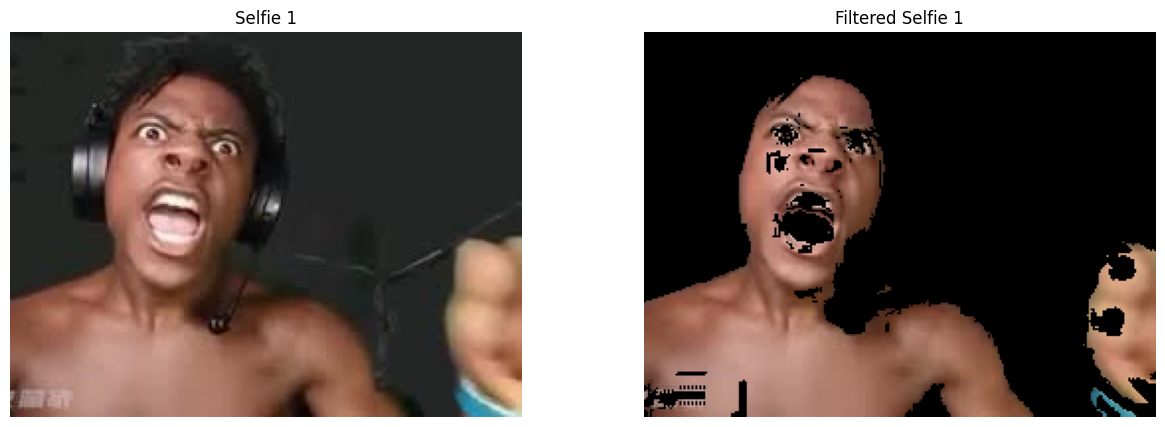

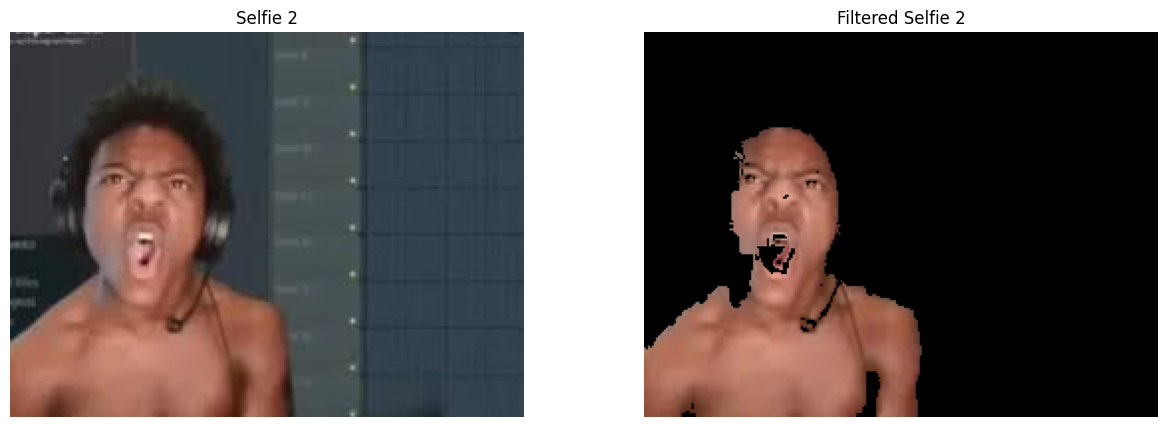

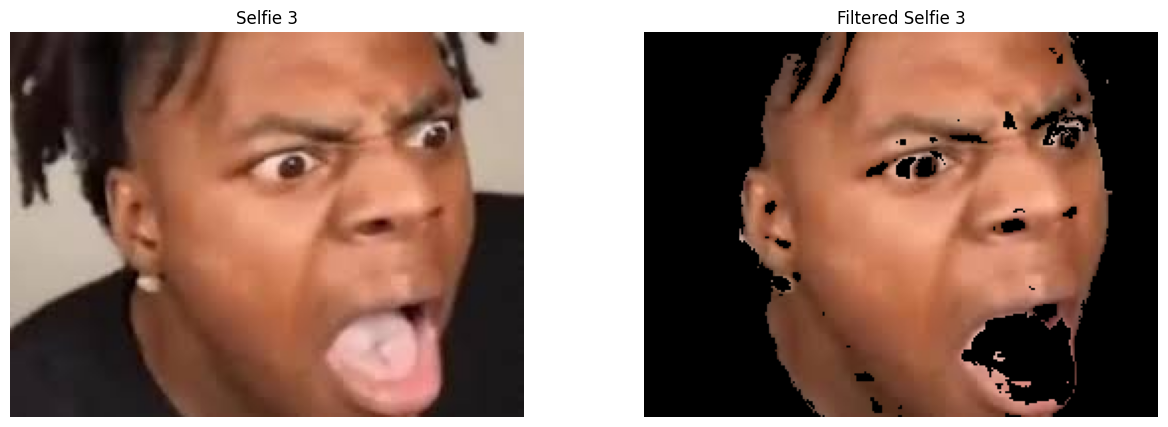

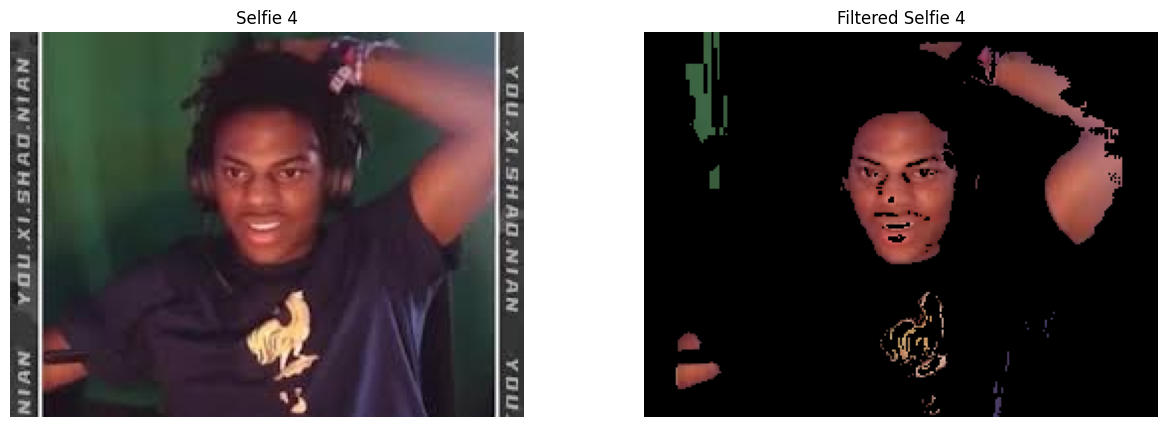

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

def load_image(file_path):
    image = cv.imread(cv.samples.findFile(file_path), cv.IMREAD_COLOR)[:,:,::-1]
    return image

def calculate_skin_range(skin_sample_paths, a=1.5):
    all_skin_ranges = []
    
    # 计算每个皮肤样本的HSV范围
    for path in skin_sample_paths:
        skin_sample = load_image(path)
        skin_sample_hsv = cv.cvtColor(skin_sample, cv.COLOR_RGB2HSV)
        mean_hsv = skin_sample_hsv.mean(axis=(0, 1))
        std_hsv = skin_sample_hsv.std(axis=(0, 1))
        
        # 计算皮肤样本的范围
        lower_range = mean_hsv - a * std_hsv
        upper_range = mean_hsv + a * std_hsv
        skin_range = (lower_range, upper_range)
        
        all_skin_ranges.append(skin_range)
    
    return all_skin_ranges

def filter_skin(image, skin_ranges):
    target_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    
    # 创建总体掩模
    total_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # 将每个皮肤样本的掩模组合起来
    for skin_range in skin_ranges:
        lower_range, upper_range = skin_range
        mask = np.logical_and.reduce(
            (target_hsv[:, :, 0] >= lower_range[0],
             target_hsv[:, :, 1] >= lower_range[1],
             target_hsv[:, :, 2] >= lower_range[2],
             target_hsv[:, :, 0] <= upper_range[0],
             target_hsv[:, :, 1] <= upper_range[1],
             target_hsv[:, :, 2] <= upper_range[2])
        ).astype(np.uint8)
        total_mask = cv.bitwise_or(total_mask, mask)
    
    # 将总体掩模应用到目标图像
    filtered_image = cv.bitwise_and(image, image, mask=total_mask)
    
    return total_mask, filtered_image

def process_images(selfie_paths, skin_sample_paths, a=1.5):
    skin_ranges = calculate_skin_range(skin_sample_paths, a=a)
    
    for i, selfie_path in enumerate(selfie_paths):
        selfie = load_image(selfie_path)
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        axs[0].imshow(selfie)
        axs[0].set_title(f'Selfie {i+1}')
        axs[0].axis('off')
        
        mask, filtered_image = filter_skin(selfie, skin_ranges)
        axs[1].imshow(filtered_image)
        axs[1].set_title(f'Filtered Selfie {i+1}')
        axs[1].axis('off')


# 图片路径
selfie_paths = ['selfie1.jpg', 'selfie2.jpg', 'selfie3.jpg', 'selfie4.jpg']
skin_sample_paths = ['skin_pixels1.jpg', 'skin_pixels2.jpg', 'skin_pixels3.jpg', 'skin_pixels4.jpg', 'skin_pixels5.jpg', 'skin_pixels6.jpg']

# 处理图片
process_images(selfie_paths, skin_sample_paths, a=2)